In [237]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import rand_score, normalized_mutual_info_score
import random
import pandas as pd


class DBSCAN_Martingale():

  def neighborhood_ordre1(self, graph, eps):

    nodes = list(graph.nodes)
    shortest_path = {node: [] for node in nodes}

    for node in nodes:
      neighbors = list(graph.neighbors(node))
      shortest_path[node] = neighbors

    return shortest_path

  def dbscan_inner(self, is_core, neighborhoods, labels):

    label_num = 1
    stack = []
    nodes = list(range(labels.shape[0]))
    #random.shuffle(nodes)

    for i in nodes:
      if labels[i] != 0 or not is_core[i]:
          continue

      # Depth-first search starting from i, ending at the non-core points.
      # This is very similar to the classic algorithm for computing connected
      # components, the difference being that we label non-core points as
      # part of a cluster (component), but don't expand their neighborhoods.
      while
      3






      True:
        if labels[i] == 0:
          labels[i] = label_num
          if is_core[i]:
            neighb = neighborhoods[i]
            for v in neighb:
              if labels[v] == 0:
                stack.append(v)

        if len(stack) == 0:
            break
        i = stack.pop()

      label_num += 1

  def dbscan_star(self, graph, eps, min_points):

    # shortest path
    neighborhoods = self.neighborhood_ordre1(graph, eps)

    n_neighbors = np.array([len(neighborhoods[neighbors]) for neighbors in range(len(graph.nodes))])

    core_samples = np.array([1 if len(neighborhoods[node]) >= min_points else 0 for node in range(len(graph.nodes))])

    labels = np.full(len(graph.nodes), 0, np.intp)

    self.dbscan_inner(core_samples,neighborhoods, labels)

    return labels

  def propagate(self, graph, eps, min_points, labels):
    neighborhoods = self.neighborhood_ordre1(graph, eps)
    n_neighbors = np.array([len(neighborhoods[neighbors]) for neighbors in range(len(graph.nodes))])
    core_samples = np.asarray(n_neighbors >= min_points, dtype=np.uint8)
    clusters = np.unique(labels [labels!=0])

    for cluster in clusters:
      nodes_in_cluster = list(np.where((labels == cluster))[0])
      L = nodes_in_cluster
      while len(L) > 0:
        node = L.pop()
        neighbors = labels[neighborhoods[node]]
        k = np.array(neighborhoods[node])
        k = k[neighbors == 0]
        neighbors[neighbors == 0] = cluster
        labels[neighborhoods[node]] = neighbors
        L.extend(list(k))

  def fit_predict(self, graph, eps, MinPts, T, realizations, ground_truth):


    # matrix of number of cluster for each min point in each realization
    realizations_DBSCAN_martingale = np.zeros((realizations, T))

    # final result of C for each realization
    principal_clustering_all = np.zeros((realizations, len(graph.nodes)))

    nmis = []
    rands = []

    for r in range(realizations):
        # number of clusters for each Min point in each realization
        number_of_clusters = []

        random_min_points = random.sample(MinPts, k=T)

        random_min_points = np.array(sorted(random_min_points, key=lambda x: -x))

        dbscan_results_all = np.zeros((len(graph.nodes), T), dtype=int)
        for j in range(T):
            dbscan_results_all[:, j] = self.dbscan_star(graph, eps, min_points=random_min_points[j])

        principal_clustering = dbscan_results_all[:, 0]

        for j in range(T):
            if np.dot(principal_clustering, dbscan_results_all[:, j]) == 0:
                b = np.max(principal_clustering)
                for i in range(len(dbscan_results_all[:, j])):
                    if dbscan_results_all[i, j] != 0:
                        dbscan_results_all[i, j] += b
                principal_clustering = principal_clustering + dbscan_results_all[:, j]
            else:
                h = np.zeros(len(principal_clustering))
                clh = np.zeros(len(principal_clustering))
                for i in range(len(principal_clustering)):
                    if principal_clustering[i] == 0 and dbscan_results_all[i, j] != 0:
                        h[i] = dbscan_results_all[i, j]
                b = np.max(principal_clustering)
                u = 0
                # if exist new labeled elements
                if np.max(h) > 0:
                    # set the new labeled elements community to r (r number of new detected communities)
                    for k in range(1, int(np.max(h)) + 1):
                        if np.sum(h == k) >= random_min_points[j]:
                            u += 1
                            clh[h == k] = u
                    # add max of C to each new detected community
                    for i in range(len(principal_clustering)):
                        if clh[i] != 0:
                            clh[i] += b
                    principal_clustering = principal_clustering + clh

            number_of_clusters.append(np.max(principal_clustering))

        # list of C(community of each node) at each realization
        principal_clustering = np.array(principal_clustering)

        #print( random_min_points[-1])

        # propagate unabelled nodes in each cluster
        self.propagate(graph, eps, random_min_points[-1], principal_clustering)

        principal_clustering_all[r, :] = principal_clustering

        ari = rand_score(ground_truth, principal_clustering)
        nmi = normalized_mutual_info_score(ground_truth, principal_clustering)


        nmis.append(nmi)
        rands.append(ari)
        #print(f"--------  {r}  ---------")

        #print(f"NMI : {nmi}")
        #print(f"RAND : {ari}")


          #print(principal_clustering)
          #print(np.max(principal_clustering))

        realizations_DBSCAN_martingale[r, :] = number_of_clusters

    df_stat = pd.DataFrame({
      "C": realizations_DBSCAN_martingale[:, -1],
      "NMI": nmis,
      "RAND": rands
    })
    df_stat.loc[:, "C"] = df_stat.loc[:, "C"].astype(int)


    # Number of clusters probability
    n_clusters, cluster_counts = np.unique(realizations_DBSCAN_martingale[:, -1], return_counts=True)
    arg_n_clusters = np.argsort(n_clusters)
    n_clusters = n_clusters[arg_n_clusters]
    cluster_counts = cluster_counts[arg_n_clusters]
    cluster_probabilities = cluster_counts / (realizations)

    #print(n_clusters)
    #print(cluster_counts)
    cluster_probabilities[n_clusters ==0 ] = 0
    # Probability distribution - barplot
    plt.bar(n_clusters, cluster_probabilities, color="blue")
    plt.xlabel("Clusters")
    plt.ylabel("Probability")
    plt.show()


    return principal_clustering_all, df_stat

In [80]:
import networkx as nx

def load_synth_graph(path):
    # Read network.dat
    G = nx.Graph()
    with open(f'{path}network.dat', 'r') as f:
        for line in f:
            parts = line.split()
            node1 = int(parts[0]) - 1
            node2 = int(parts[1]) - 1
            G.add_edge(node1, node2)

    # Read community.dat
    communities = []
    with open(f'{path}community.dat', 'r') as f:
        for line in f:
            parts = line.split()
            node = int(parts[0]) - 1
            community = int(parts[1])
            communities.append(community)

    return G, communities

## **LFR 1 (650 node)**

In [150]:
G, ground_truth = load_synth_graph("./")

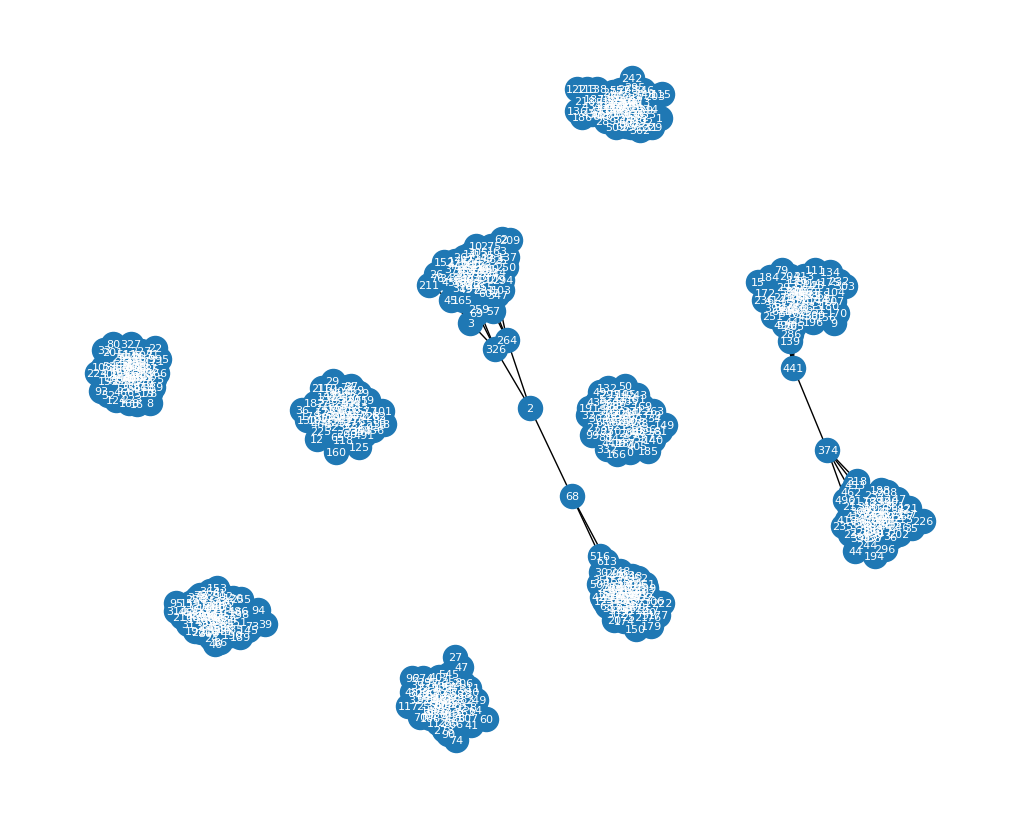

In [151]:
# Create a figure object with a larger size
plt.figure(figsize=(10, 8))
# Draw the graph
nx.draw(G, pos=nx.spring_layout(G), with_labels=True, node_size=300, font_color="white", font_size=8)
# Display the graph
plt.show()

<ipython-input-129-bbdaf50cd1af>:173: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_stat.loc[:, "C"] = df_stat.loc[:, "C"].astype(int)


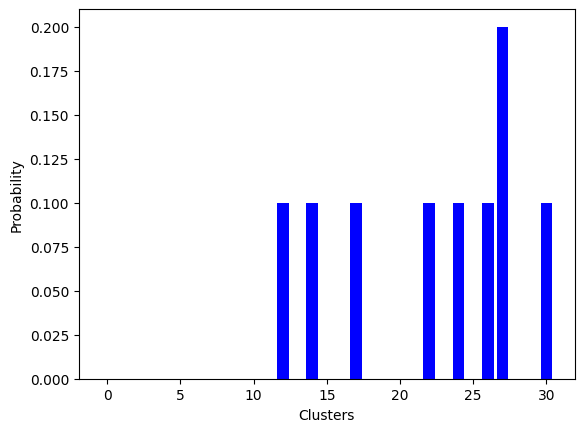

nmi average: 0.8782503023643718
rand average: 0.9609339812729645


In [152]:
# DBSCAN* clustering
eps = 1
T = 5
realizations = 10
MinPts = range(5,30)
dbscan_star = DBSCAN_Martingale()
principal_clustering_all, df_stat = dbscan_star.fit_predict(G, eps, MinPts, T, realizations, ground_truth)

print(f"nmi average: {np.mean(df_stat.loc[df_stat.iloc[:, 0] != 0, 'NMI'])}")
print(f"rand average: {np.mean(df_stat.loc[df_stat.iloc[:, 0] != 0, 'RAND'])}")

In [153]:
df_stat

,C,NMI,RAND
0,27,0.845684,0.949157
1,0,0.000000,0.098613
2,27,0.845684,0.949157
3,17,0.946204,0.985364
4,30,0.832220,0.948598
5,22,0.860139,0.953168
6,26,0.838749,0.947171
7,14,0.911304,0.970558
8,12,0.982733,0.996439
9,24,0.841536,0.948792


In [154]:
max_nmi_idx = df_stat['NMI'].idxmax()
max_rand_idx = df_stat['RAND'].idxmax()

# Extract rows with the highest NMI and RAND values
row_highest_nmi = df_stat.loc[max_nmi_idx]
row_highest_rand = df_stat.loc[max_rand_idx]
print("cluster with the highest NMI")
print(row_highest_nmi)
print()
print("cluster with the highest RAND")
print(row_highest_rand)

cluster with the highest NMI
C       12.000000
NMI      0.982733
RAND     0.996439
Name: 8, dtype: float64

cluster with the highest RAND
C       12.000000
NMI      0.982733
RAND     0.996439
Name: 8, dtype: float64


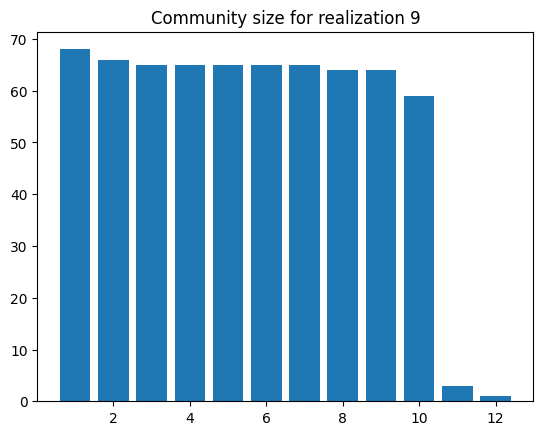

In [155]:
unique_elements, counts = np.unique(principal_clustering_all[max_nmi_idx], return_counts=True)
counts = sorted(counts, key=lambda x: -x)
plt.bar(x=unique_elements, height=counts)
plt.title(f"Community size for realization {max_nmi_idx + 1}")
plt.show()

## **Polbooks**


In [245]:
G = nx.read_gml('polbooks.gml', label=None)

In [246]:
ground_truth = np.array([0,1,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0])

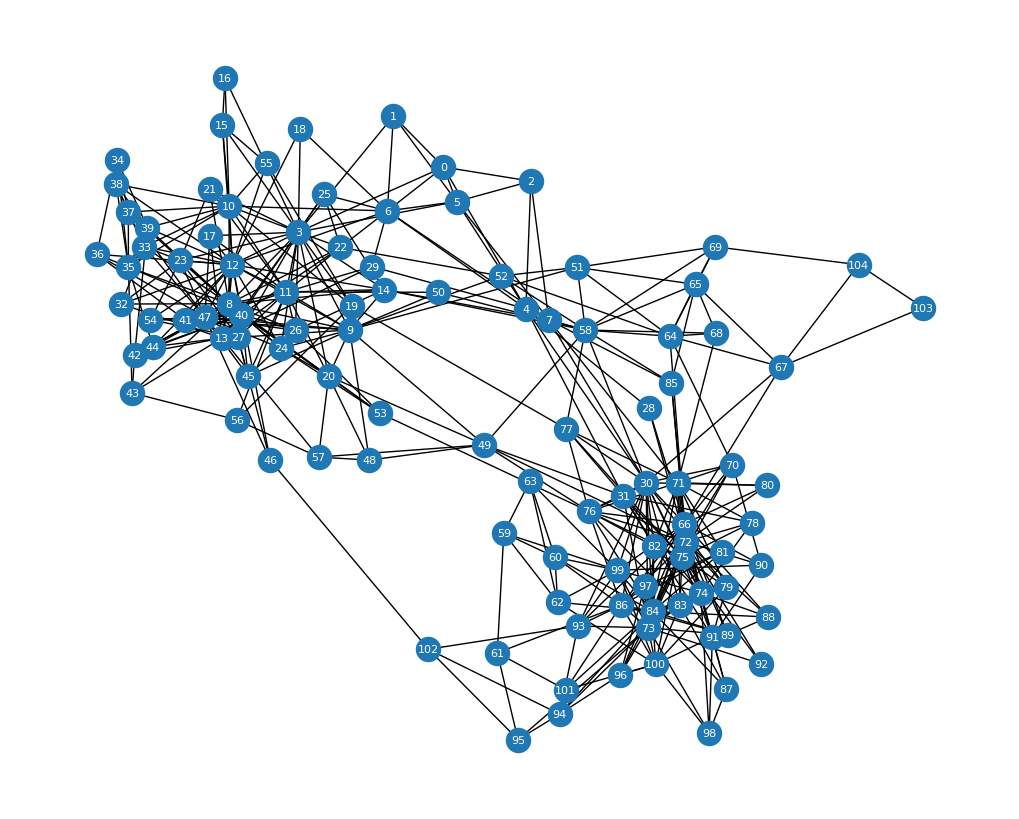

In [247]:
# Create a figure object with a larger size
plt.figure(figsize=(10, 8))
# Draw the graph
nx.draw(G, pos=nx.spring_layout(G), with_labels=True, node_size=300, font_color="white", font_size=8)
# Display the graph
plt.show()

<ipython-input-237-bbdaf50cd1af>:173: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_stat.loc[:, "C"] = df_stat.loc[:, "C"].astype(int)


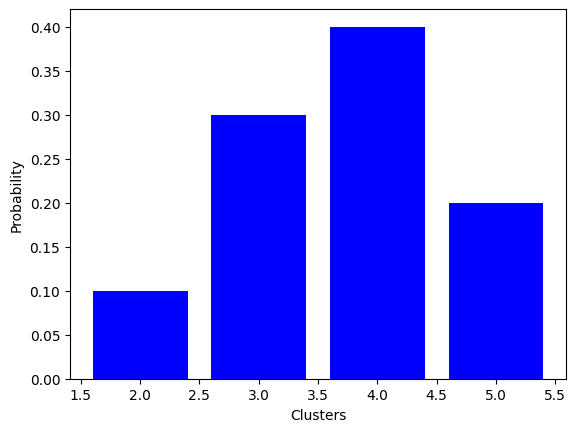

nmi average: 0.4272614089275903
rand average: 0.7495604395604396


In [248]:
# DBSCAN* clustering
eps = 1
T = 5
realizations = 10
MinPts = range(5,30)
dbscan_star = DBSCAN_Martingale()
principal_clustering_all, df_stat = dbscan_star.fit_predict(G, eps, MinPts, T, realizations, ground_truth)

print(f"nmi average: {np.mean(df_stat.loc[df_stat.iloc[:, 0] != 0, 'NMI'])}")
print(f"rand average: {np.mean(df_stat.loc[df_stat.iloc[:, 0] != 0, 'RAND'])}")

In [249]:
df_stat

,C,NMI,RAND
0,4,0.439856,0.765751
1,5,0.449770,0.754762
2,3,0.425329,0.769048
3,5,0.416962,0.752564
4,2,0.376139,0.689194
5,4,0.377123,0.736447
6,4,0.432164,0.759524
7,3,0.485747,0.769048
8,3,0.415918,0.759890
9,4,0.453608,0.739377


In [250]:
max_nmi_idx = df_stat['NMI'].idxmax()
max_rand_idx = df_stat['RAND'].idxmax()

# Extract rows with the highest NMI and RAND values
row_highest_nmi = df_stat.loc[max_nmi_idx]
row_highest_rand = df_stat.loc[max_rand_idx]
print("cluster with the highest NMI")
print(row_highest_nmi)
print()
print("cluster with the highest RAND")
print(row_highest_rand)

cluster with the highest NMI
C       3.000000
NMI     0.485747
RAND    0.769048
Name: 7, dtype: float64

cluster with the highest RAND
C       3.000000
NMI     0.425329
RAND    0.769048
Name: 2, dtype: float64


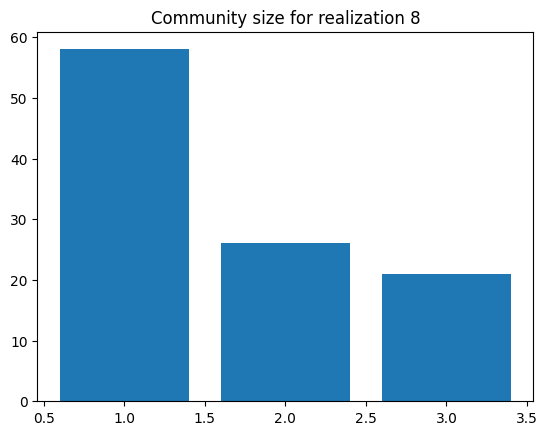

In [251]:
unique_elements, counts = np.unique(principal_clustering_all[max_nmi_idx], return_counts=True)
counts = sorted(counts, key=lambda x: -x)
plt.bar(x=unique_elements, height=counts)
plt.title(f"Community size for realization {max_nmi_idx + 1}")
plt.show()